In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [21]:
#export
from exp.nb_06 import *

In [7]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [8]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [32]:
class Learner():
    def __init__(self, model, opt, loss_func,  data, lr=1e-2, cbs=None, cb_funcs=None):
        self.model, self.opt, self.loss_func, self.data, self.lr = *get_model(data,lr), loss_func, data, lr
        self.in_train = False
        
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))
        
    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
    
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        
    def remove_cbs(self,cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def one_epoch(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')  
    
    def fit(self, epochs, cbs=None):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                if not self.do_begin_epoch(epoch): self.one_epoch()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.one_epoch()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
            
    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
        
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res        

In [41]:
def get_learner(data,loss_func,lr=0.5,**kwargs):
    return Learner(*get_model(data),loss_func,data,lr,**kwargs)

In [42]:
stats = AvgStatsCallback([accuracy])

In [47]:
learn = get_learner(data,loss_func,lr=0.5,cbs=stats)

In [49]:
learn.fit(3)

train: [0.110692412109375, tensor(0.9656)]
valid: [0.12275120849609375, tensor(0.9622)]
train: [0.0887837109375, tensor(0.9722)]
valid: [0.1044952392578125, tensor(0.9685)]
train: [0.07564525390625, tensor(0.9762)]
valid: [0.10490494384765625, tensor(0.9689)]


In [52]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [53]:
learn = get_learner(data,loss_func,lr=0.5,cb_funcs = cbfs)

In [54]:
learn.fit(3)

train: [0.3645453125, tensor(0.8923)]
valid: [0.19918575439453126, tensor(0.9375)]
train: [0.154488994140625, tensor(0.9537)]
valid: [0.1345205078125, tensor(0.9581)]
train: [0.09321048828125, tensor(0.9711)]
valid: [0.10029873046875, tensor(0.9716)]


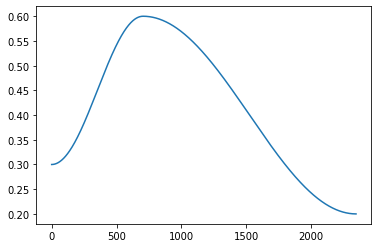

In [55]:
learn.recorder.plot_lr()

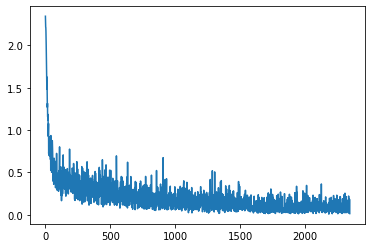

In [56]:
learn.recorder.plot_loss()

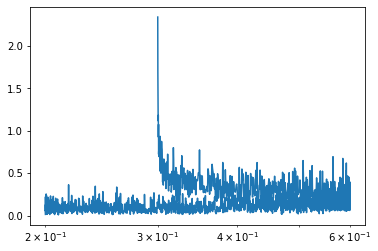

In [57]:
learn.recorder.plot()